# **1. Importing the unimputed dataset**


In [56]:
import pandas as pd
from sklearn.preprocessing import OrdinalEncoder
import seaborn as sns
import matplotlib.pyplot as plt
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant

In [57]:
unimputed_data = pd.read_csv("data/Quang/UnImputedDataWithIDs.csv").drop(columns = ["Unnamed: 0", "ID", "Floors", "Entrance (m2)", "Living Rooms"], axis=1)

In [58]:
unimputed_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27544 entries, 0 to 27543
Data columns (total 9 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Quarter              27544 non-null  int64  
 1   Year                 27544 non-null  int64  
 2   District             27544 non-null  object 
 3   Price (billion VND)  27544 non-null  float64
 4   Area (m2)            26903 non-null  float64
 5   Property Type        27544 non-null  object 
 6   Bathrooms            14166 non-null  float64
 7   Bedrooms             15710 non-null  float64
 8   Law Document         27544 non-null  object 
dtypes: float64(4), int64(2), object(3)
memory usage: 1.9+ MB


In [59]:
imputed_data = pd.read_csv("data/Quang/quang.csv")[["Quarter", "Year", "District", "Price (billion VND)", "Area (m2)", "Property Type", "Bathrooms", "Bedrooms", "Law Document"]]
imputed_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27537 entries, 0 to 27536
Data columns (total 9 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Quarter              27537 non-null  int64  
 1   Year                 27537 non-null  int64  
 2   District             27537 non-null  object 
 3   Price (billion VND)  27537 non-null  float64
 4   Area (m2)            27537 non-null  float64
 5   Property Type        27537 non-null  object 
 6   Bathrooms            27537 non-null  float64
 7   Bedrooms             27537 non-null  float64
 8   Law Document         27537 non-null  object 
dtypes: float64(4), int64(2), object(3)
memory usage: 1.9+ MB


# **2. Defining methods to detect multicollinearity**


In [60]:
from sklearn.preprocessing import StandardScaler
def numerical_convert(data: pd.DataFrame, categorical_encoder) -> any:
    """ Return the converted DataFrame and the transformation dictionary """
    transform_dict = dict()
    converted_data = data.copy()
    object_cols = data.select_dtypes(include=["object"]).columns
    for col in object_cols:
        converted_data[col] = categorical_encoder.fit_transform(data[[col]])
        transform_dict[col] = list(zip(converted_data[col].unique(), data[col].unique()))
    return converted_data, transform_dict
    
def correlation_map(converted_data: pd.DataFrame) -> None:
    """ Showing the correlation between any 2 variables """
    corr_matrix = converted_data.corr()
    plt.figure(figsize=(10, 6))
    ax = sns.heatmap(corr_matrix, cmap="coolwarm", annot=True, fmt=".2f", linewidths=.5, linecolor="black")
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
    plt.title("Correlations between every 2 fields", fontweight="bold")
    return

def VIF_values(converted_data: pd.DataFrame, scaled_fields = ["Quarter", "Year", "Area (m2)", "Price (billion VND)", "Bathrooms", "Bedrooms"]):
    """ Showing the Variance Inflation Factor (VIF) for each field """
    scaled_data = converted_data.copy()
    scaler = StandardScaler()
    scaled_data[scaled_fields] = scaler.fit_transform(scaled_data[scaled_fields])
    X = add_constant(scaled_data)
    vif_df = pd.DataFrame()
    vif_df["Fields"] = X.columns
    vif_df["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
    return vif_df

## **2.1. Correlation matrix visualized for unimputed dataset**


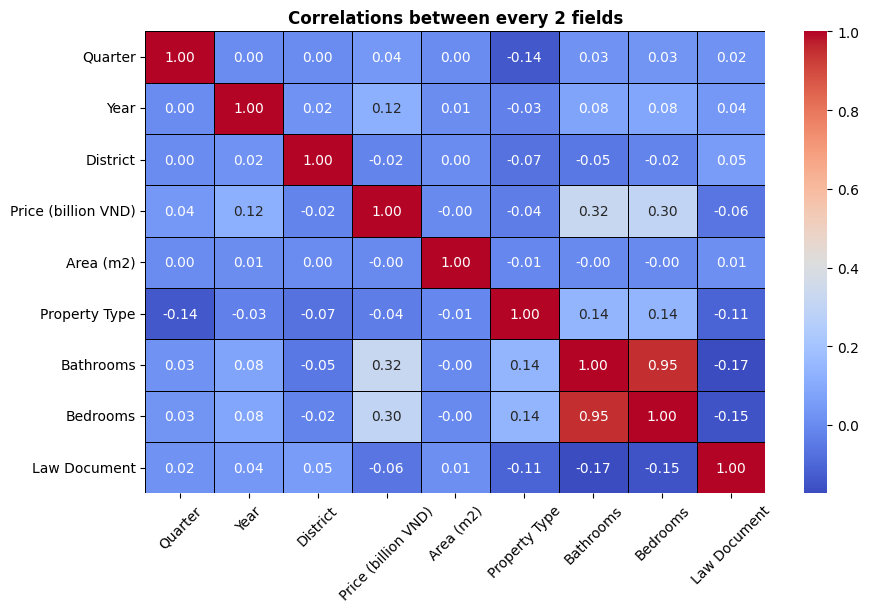

In [61]:
# Correlation between any 2 fields
encode_unimputed = numerical_convert(unimputed_data, OrdinalEncoder())[0]
correlation_map(encode_unimputed)

## **2.2. Correlation matrix visualized for the Complete Case Dataset**


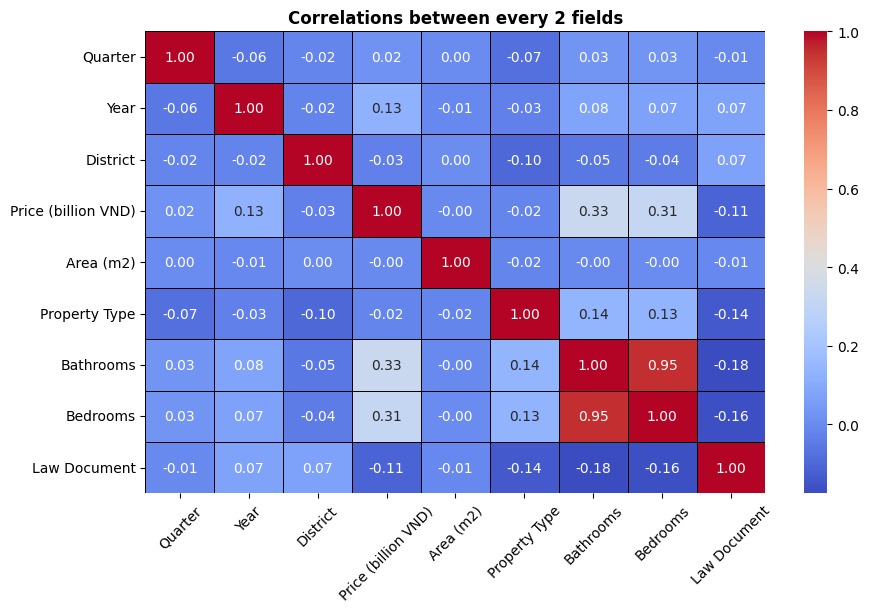

In [62]:
complete_case = unimputed_data.dropna(how="any")
encode_complete = numerical_convert(complete_case, OrdinalEncoder())[0]
correlation_map(encode_complete)

In [63]:
# Variance inflation factors for each fields
print(VIF_values(encode_complete))

                Fields        VIF
0                const  14.752879
1              Quarter   1.011924
2                 Year   1.033657
3             District   1.016761
4  Price (billion VND)   1.146317
5            Area (m2)   1.000412
6        Property Type   1.055991
7            Bathrooms  11.238347
8             Bedrooms  11.031378
9         Law Document   1.062577


## **2.3. Correlation matrix visualized for imputed dataset**

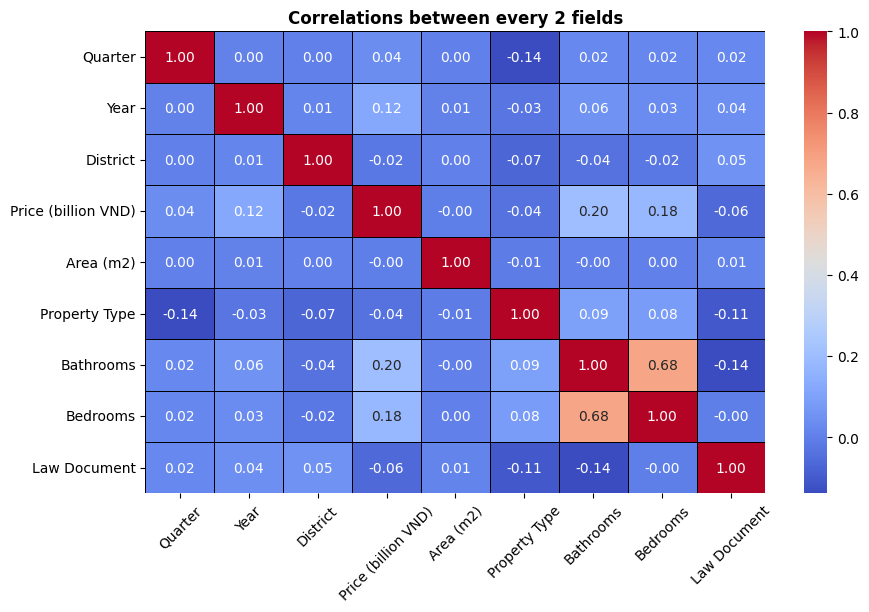

In [64]:
encode_imputed = numerical_convert(imputed_data, OrdinalEncoder())[0]
correlation_map(encode_imputed)

In [65]:
# Variance inflation factors (VIF) for each field
print(VIF_values(encode_imputed))

                Fields        VIF
0                const  14.601436
1              Quarter   1.021989
2                 Year   1.020140
3             District   1.008204
4  Price (billion VND)   1.067369
5            Area (m2)   1.000243
6        Property Type   1.048604
7            Bathrooms   1.958311
8             Bedrooms   1.904018
9         Law Document   1.051660


## The heatmap and VIF values have shown that:

- There is **no severe multicollinearity** in our dataset after imputations.
- However, there is **collinearity** between the <code>Bathrooms</code> and <code>Bedrooms</code>.
